## 27 - Micromapping
>Map something small and precise. Zoom in and map a small area in high detail. It could be a single building, a street corner, or a tiny plot of land. Focus on accuracy at a small scale. 🧐🔍

In [1]:
import matplotlib.pyplot as plt
import osmnx as ox
import cartopy.crs as ccrs
from matplotlib import patheffects as path_effects
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
mn = ox.geocode_to_gdf('Micronesia')

islands = mn.explode(index_parts=True, ignore_index=True).drop(columns=['bbox_north','bbox_south','bbox_east','bbox_west','place_id',
                                                                        'osm_type','osm_id','lat','lon','class','type','place_rank',
                                                                        'importance','addresstype','display_name'])

prj = islands.estimate_utm_crs()
islands.to_crs(prj, inplace=True)
islands['area'] = islands.area

islands = islands.sort_values(by='area').reset_index(drop=True)

# smallest island, which happens to be called pikelot
pikelot = islands.loc[[0]]
lon, lat = pikelot.centroid.to_crs(4326)[0].xy

features = ox.features_from_polygon(pikelot.to_crs(4326).loc[0,'geometry'],
                                    tags={'natural':True,
                                          'building': True
                                          }).to_crs(prj)

building = features.loc[~features['building'].isna()]
coastline = features.loc[features['natural']=='coastline']
wood = features.loc[features['natural']=='wood']
reef = features.loc[features['natural']=='reef']
beach = features.loc[features['natural']=='beach']

minx, miny, maxx, maxy = beach.total_bounds

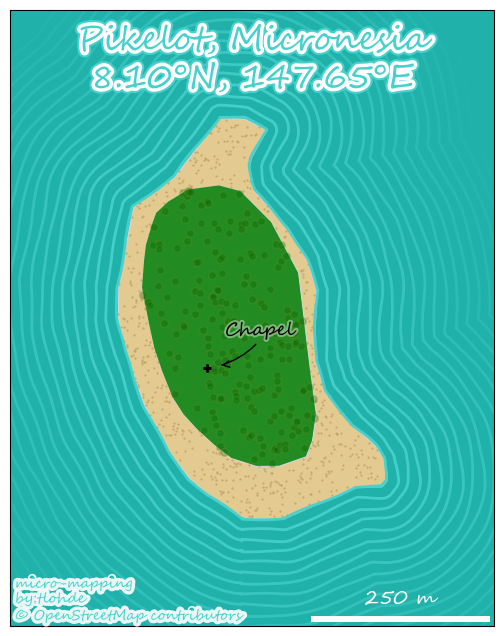

In [3]:
fig, ax = plt.subplots(figsize=[8,8],
                       subplot_kw={'projection':ccrs.UTM(56)})

with plt.xkcd():
    plt.rcParams['path.effects'] = [] # override xkcd's white path effects
    
    # coastline.plot(ax=ax, color='lightgray')

    beach.plot(ax=ax, color='#e3ca91', ec='lightgray')
    beach.sample_points(500).plot(ax=ax, marker='.', markersize=1, c='#bfa363')

    for b in range(1,300,15):
        alph = 1 - b/300
        ax.plot(*beach.geometry.iloc[0].exterior.buffer(b).exterior.coords.xy,
                c='mediumturquoise',
                alpha=alph)

    wood.plot(ax=ax, color='forestgreen')
    wood.sample_points(200).plot(ax=ax,
                                 marker='o',
                                 markersize=30,
                                 ec='olivedrab',
                                 fc='darkgreen',
                                 alpha=0.3)

    
    building.centroid.plot(ax=ax,
                           marker='+',
                           markersize=40,
                           color='k',
                           zorder=10)
    
    ax.set(xlim=(minx-150, maxx+150),
        ylim=(miny-150, maxy+150))

    ax.set_facecolor('lightseagreen')

    ax.set_title(f'Pikelot, Micronesia\n{lat[0]:.2f}°N, {lon[0]:.2f}°E',
                y=0.86,
                #  x=0.56,
                ha='center',
                font='Segoe Script',
                fontsize=24,
                color='mediumturquoise',
                path_effects=[path_effects.Stroke(linewidth=8, foreground='mediumturquoise'),
                            path_effects.Stroke(linewidth=5, foreground='w'),
                            path_effects.Normal()])

    x, y = building.centroid.iloc[0].xy
    ax.annotate('Chapel',
                xy=(x[0]+15, y[0]+2),
                xytext=(x[0]+25, y[0]+45),
                font='Segoe Script',
                fontsize=13,
                arrowprops={'arrowstyle':'->',
                            'ec':'k',
                            'relpos':(0.5, 0),
                            'connectionstyle':"arc3, rad=-0.2"},
                path_effects=[path_effects.Stroke(linewidth=3, foreground='w', alpha=0.4),
                            path_effects.Normal()]
                )
        
            
    ax.annotate( 
        'micro-mapping\nby:tlohde\n© OpenStreetMap contributors',
        xy=(0.01, 0.01),
        # ha='center',
        xycoords='axes fraction',
        font_properties={
            'family': 'Segoe Script',
            'size': 10,
            },
        color='mediumturquoise',
        path_effects=[path_effects.Stroke(linewidth=5, foreground='w', alpha=0.9),
                    path_effects.Normal()]
    )
    ax.add_artist(ScaleBar(1,
                        fixed_value=250,
                        location='lower right',
                        scale_loc='top',
                        color='w',
                        box_alpha=0,
                        font_properties={'family':'Segoe Script'}, ),
              )
    
fig.savefig('day27.png', dpi=300, bbox_inches='tight')